<a href="https://colab.research.google.com/github/Mollylst/resnet18/blob/main/deepfake_resnet_20k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import os
from torchvision import datasets 
import torchvision.transforms as transforms

#prepare dataset and preprocessing
data_dir='/content/drive/MyDrive/real_fake_20000'

transform_train = transforms.Compose([
    transforms.Resize((36, 36)),  # Resizes (32,32) to (36,36)
    transforms.RandomCrop((32, 32)),  # Takes a random (32,32) crop
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform_test = transforms.Compose([
     transforms.Resize((36, 36)),  # Resizes (32,32) to (36,36)
     transforms.RandomCrop((32, 32)),  # Takes a random (32,32) crop
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

batch_size = 128

trainset = datasets.ImageFolder(data_dir+'/train',transform=transform_train)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.ImageFolder(data_dir+'/test',transform=transform_test)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x)) for x in ['train', 'test']}
classes = image_datasets['train'].classes
print(classes)
#classes = ('fake', 'real')

['fake', 'real']


images-size: torch.Size([128, 3, 32, 32])


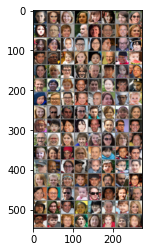

 real  real  real  fake  fake  fake  real  fake  real  fake  fake  fake  real  real  fake  real  real  fake  fake  real  fake  fake  real  real  real  fake  real  fake  fake  fake  real  real  fake  fake  fake  real  fake  fake  fake  fake  fake  real  real  fake  real  real  real  fake  real  fake  fake  real  fake  real  real  fake  fake  real  fake  fake  real  fake  real  fake  fake  real  fake  fake  real  fake  fake  fake  fake  real  fake  real  fake  fake  fake  real  fake  fake  fake  real  fake  real  real  real  fake  fake  real  real  fake  fake  real  fake  fake  real  real  real  real  fake  real  real  fake  real  fake  fake  real  fake  real  real  fake  real  real  fake  fake  fake  fake  real  fake  fake  fake  fake  real  fake  fake  real


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()


print("images-size:", images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.reshape(out.shape[0],-1)
        #out = F.avg_pool2d(out, 4)
        #out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

#define ResNet18
net = ResNet18().to(device)

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15, eta_min=0, last_epoch=-1, verbose=False)

In [ ]:
import time
num_epoch=15

def train_and_test():
    history = []
    best_acc = 0.0
    best_epoch = 0
    
    for epoch in range(0,num_epoch):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, num_epoch))

        net.train()
        train_loss = 0.0
        train_acc = 0.0
        test_loss = 0.0
        test_acc = 0.0

        #train
        for i, (inputs, labels) in enumerate(trainloader):

            inputs, labels = inputs.to(device), labels.to(device)
 
            #the gradient is increasing, so make it zero
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
 
            train_loss += loss.item() * inputs.size(0)
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            train_acc += acc.item() * inputs.size(0)

        #test
        net.eval()
        with torch.no_grad():

            for j, (inputs, labels) in enumerate(testloader):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
 
                loss = criterion(outputs, labels)
 
                test_loss += loss.item() * inputs.size(0)
 
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
 
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
 
                test_acc += acc.item() * inputs.size(0)
 
        avg_train_loss = train_loss/ len(trainset)
        avg_train_acc = train_acc/ len(trainset)
 
        avg_test_loss = test_loss/len(testset)
        avg_test_acc = test_acc/len(testset)

        #record the accuracy and loss in each epoch
        history.append([avg_train_loss, avg_test_loss, avg_train_acc, avg_test_acc])
 
        if best_acc < avg_test_acc:
            best_acc = avg_test_acc
            best_epoch = epoch + 1

        scheduler.step()  

        epoch_end = time.time()
        
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tTest: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_train_loss, avg_train_acc*100, avg_test_loss, avg_test_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for test : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))
          
    return history
    
#start training and testing
history = train_and_test()

#make the plots
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

Epoch: 1/15


KeyboardInterrupt: ignored

In [ ]:
PATH = './real_fake.pth'
torch.save(net.state_dict(), PATH)